In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

import Models_MNIST as mds

# Hyper Parameters
EPOCH = 100
BATCH_SIZE = 256
DOWNLOAD_MNIST = False
m1 = 64
m2 = 128
m3 = 512
cudaopt = True

EPS = 1e-4

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# LIMITING TRAINING DATA
Ntrain = int(60e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

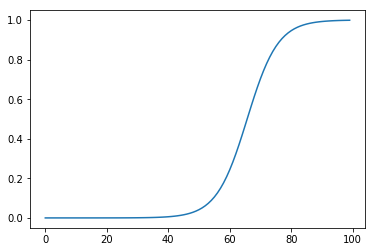

In [2]:
x = np.linspace(1,EPOCH,EPOCH)
Rhos = 1/(1+np.exp(-(x- EPOCH*6/9 )*.2))
plt.plot(Rhos)

### Model Baseline

In [3]:
Loss_test_0 = np.zeros((EPOCH,))
Acc_test_0 = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Baseline\n')
    
model = mds.ML_ISTA_NET(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model(b_x)
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model(b_x)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_0[epoch] = test_loss
    Acc_test_0[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model.state_dict(), 'cnn_model.pt')


					Training Baseline



/ |#                                                  | 0 Elapsed Time: 0:00:00/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


KeyboardInterrupt: 

### ML-JISTA TESTING

In [ ]:
# importlib.reload(mds)

# T = 0
# RHO =  float(Rhos[0])

# dataiter = iter(train_loader)
# x, labels = dataiter.next()

# model = mds.ML_JISTA_NET(m1,m2,m3)
# x = Variable(x)# batch x, shape (batch, 28*28)
# labels = Variable(labels)
# # print(x.shape)
# # print(labels.shape)

# temp = np.empty(labels.shape[0])
# # print(temp.shape)

# encoded, scores, sorted_labels = model.joint_train(x, labels, T, RHO)

# # print(scores.shape)
# # print(sorted_labels.shape)
# # print(type(scores))
# # print(type(sorted_labels))

# loss = F.nll_loss(scores, sorted_labels)  
# optimizer.zero_grad()               
# loss.backward()                     
# optimizer.step()

# X1 = torch.rand(4,6,1,1)
# X1_dims = list(X1.shape)
# X1_mat = X1.view(-1, X1_dims[1])
# st_factors = 1-2/(torch.sum(X1_mat**2, dim=0))
# st_factors_mat = torch.diag(st_factors)
# X2_mat = F.relu(torch.t(torch.mm(st_factors_mat, torch.t(X1_mat))))
# X2 = X2_mat.view(X1_dims[0], X1_dims[1], X1_dims[2], X1_dims[3])
# print(X1_mat)
# print(X2_mat)

### ML-JISTA

In [ ]:
importlib.reload(mds)

Loss_test_ista_r = np.zeros((EPOCH,))
Acc_test_jista_r = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining ML-JISTA \n')

T = 4  # number of unfoldings/iterations of ml-ista

model = mds.ML_JISTA_NET(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
#     print("Epoch: " + str(int(epoch)))
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    
    RHO =  float(Rhos[epoch])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores, sorted_labels = model.joint_train(b_x, b_y, T, RHO)
#         print(type(sorted_labels))
        sorted_labels = sorted_labels.type(torch.cuda.LongTensor)
#         scores = scores.type(torch.cuda.LongTensor)
#         print(type(sorted_labels))
        scores.type(torch.cuda.LongTensor)
#         print(scores.shape)
#         print(b_y.shape)
        
        loss = F.nll_loss(scores, sorted_labels)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
#         print(loss)
    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model.forward(b_x,T,RHO)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_ista_r[epoch] = test_loss
    Acc_test_jista_r[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
#     print("Performance at epoch " + str(int(epoch)) + ": " + str(Acc_test_ista_r[epoch]))
    
torch.save(model.state_dict(), 'mljista_model.pt')

### ML-ISTA

In [ ]:
Loss_test_ista_r = np.zeros((EPOCH,))
Acc_test_ista_r = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining ML-ISTA \n')

T = 4  # number of unfoldings/iterations of ml-ista

model = mds.ML_ISTA_NET(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
#     print("Epoch: " + str(int(epoch)))
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    
    RHO =  float(Rhos[epoch])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model(b_x,T,RHO)
        
#         print(scores.shape)
#         print(b_y.shape)
        
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model(b_x,T,RHO)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_ista_r[epoch] = test_loss
    Acc_test_ista_r[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model.state_dict(), 'mlista_model.pt')

### ML-FISTA 

In [ ]:
Loss_test_fista_r = np.zeros((EPOCH,))
Acc_test_fista_r = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining ML-FISTA \n')

model = mds.ML_FISTA_NET(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    
    RHO = float(Rhos[epoch])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model(b_x,T,RHO)
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model(b_x,T,RHO)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_fista_r[epoch] = test_loss
    Acc_test_fista_r[epoch] =  100 * float(correct) /float(len(test_loader.dataset))

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(Acc_test_0, linewidth = 2,label='baseline')
plt.plot(Acc_test_ista_r, linewidth = 2,label = 'ML-ISTA')
plt.plot(Acc_test_jista_r, linewidth = 2,label = 'ML-JISTA')
# plt.plot(Acc_test_fista_r, linewidth = 2,label = 'ML-FISTA')

plt.grid('on')
plt.title('Test Accuracy - 4 Unfoldings')
plt.legend()
plt.axis([0, 100, 95, 100])
plt.show()